In [6]:
#!/usr/bin/env python3.4

import os
import sys
import re
import cv2
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu
from plugin.FastBlend.api import check_input_for_blending
from plugin.FastBlend.runners.fast import TableManager, PyramidPatchMatcher

## 0. Data loading

In [9]:
input_dir = "../workdir/carla/iclight_vidtome/routes_town01_02_06_20_36_50_lmr_0.9_gmr_0.8_alpha_t_0.0"
video_guide = os.path.join(input_dir, "output_gt.mp4")
video_style = os.path.join(input_dir, "output.mp4")
frames_guide, frames_style, message = check_input_for_blending(video_guide, None, video_style, None)

In [10]:
mode = "Fast"
if mode == "Fast" or mode == "Balanced":
    tracking_window_size = 0
ebsynth_config = {
    "minimum_patch_size": 5,
    "threads_per_block": 8,
    "num_iter": 2,
    "gpu_id": 0,
    "guide_weight": 10.0,
    "initialize": "identity",
    "tracking_window_size": tracking_window_size,
}

window_size = 15
batch_size = 16

frames_guide = frames_guide.raw_data()
frames_style = frames_style.raw_data()
table_manager = TableManager()
patch_match_engine = PyramidPatchMatcher(
    image_height=frames_style[0].shape[0],
    image_width=frames_style[0].shape[1],
    channel=3,
    **ebsynth_config
)

In [ ]:
# left part
table_l_rt = table_manager.build_remapping_table(frames_guide, frames_style, patch_match_engine, batch_size, desc="Fast Mode Step 1/4")
table_l_bt = table_manager.remapping_table_to_blending_table(table_l_rt)
table_l = table_manager.process_window_sum(frames_guide, table_l_bt, patch_match_engine, window_size, batch_size, desc="Fast Mode Step 2/4")
# right part
table_r_rt = table_manager.build_remapping_table(frames_guide[::-1], frames_style[::-1], patch_match_engine, batch_size, desc="Fast Mode Step 3/4")
table_r_bt = table_manager.remapping_table_to_blending_table(table_r_rt)
table_r = table_manager.process_window_sum(frames_guide[::-1], table_r_bt, patch_match_engine, window_size, batch_size, desc="Fast Mode Step 4/4")[::-1]

Level of left table: 1
Level of right table: 0


(-0.5, 959.5, 535.5, -0.5)

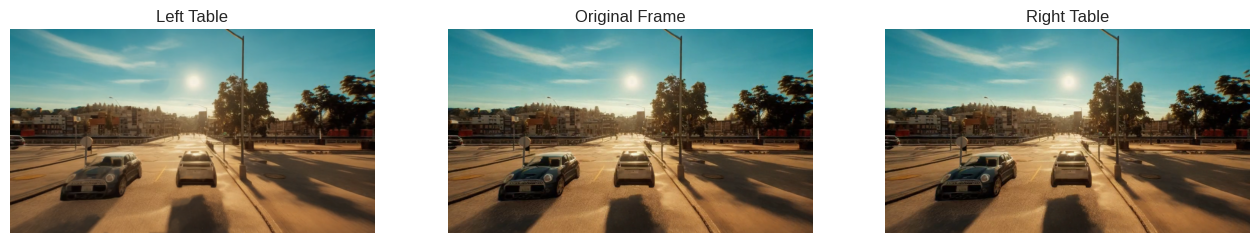

In [141]:
idx = random.randint(0, len(frames_style) - 1)
level_l = random.randint(0, len(table_l_rt[idx]) - 1)
level_r = random.randint(0, len(table_r_rt[len(frames_style)-1-idx]) - 1)
print(f"Level of left table: {level_l}")
print(f"Level of right table: {level_r}")

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.title("Left Table")
# plt.imshow(table_l[idx][0].clip(0, 255).astype("uint8"))
plt.imshow(table_l_rt[idx][level_l][0].clip(0, 255).astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Original Frame")
plt.imshow(frames_style[idx])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Right Table")
# plt.imshow(table_r[idx][0].clip(0, 255).astype("uint8"))
plt.imshow(table_r_rt[len(frames_style)-1-idx][level_r][0].clip(0, 255).astype("uint8"))
plt.axis("off")